<a href="https://colab.research.google.com/github/jpark77/ML-with-R-for-fun-seriously/blob/master/Seoul_Crime_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
import requests
import folium
import json

import numpy as np
import pandas as pd

import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans

In [3]:
from google.colab import files
import io
import os
import warnings
warnings.filterwarnings("ignore")

In this assignment, I will explore the crime rate for Seoul's 25 boroughs.
Here I will instead use GoogpleMaps API (e.g. Geocode API) to get the location data of police stations. I then will employ powerful visualization libraries, e.g. Seaborn and Matplolib, and data manipulation techiques using Pandas to summarize criminal activities within those districts. And subsequently, I will make a policy recommendation according to the results.   

In [ ]:
# Seoul's location info
# latitude = 37.5666791
# longitude = 126.9782914


In [94]:
uploaded = files.upload()

Saving seoul_geoinfo.json to seoul_geoinfo.json


In [66]:
df_crime_seoul = pd.read_csv(r'/content/crime_seoul.csv', thousands=',')

In [84]:
# Info on Seoul's Surveilance Cameras
seoul_cctv = pd.read_csv(r'/content/seoul_cctv.csv', thousands=',', 
                          encoding='UTF-8', index_col='borough')

In [97]:
# JSON containing seoul's geo-information
seoul_geo = json.load(open(r'/content/seoul_geoinfo.json', encoding='utf-8'))

A brief look into crime by Seoul's each districts 

1.   Getting the geolactions of each police station
2.   Using Pivot Table to aggregate the crime status by each district



In [67]:
df_crime_seoul.head()

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거
0,중부서,2,2,3,2,105,65,1395,477,1355,1170
1,종로서,3,3,6,5,115,98,1070,413,1278,1070
2,남대문서,1,0,6,4,65,46,1153,382,869,794
3,서대문서,2,2,5,4,154,124,1812,738,2056,1711
4,혜화서,3,2,5,4,96,63,1114,424,1015,861


In [68]:
# Translating the column names in Korean into ones in English

df_crime_seoul.rename(columns={'관서명':"Police_Dept",
                     '살인 발생':"Homicide",
                     '살인 검거':'Homicide_Arrested',
                     '강도 발생':'Robbery',
                     '강도 검거':'Robbery_Arrested',
                     '강간 발생':'Rape',
                     '강간 검거':'Rape_Arrested',
                     '절도 발생':'Theft',
                     '절도 검거':'Theft_Arrested',
                     '폭력 발생':'Violence',
                     '폭력 검거':'Violence_Arrested'
                     }, errors="raise", inplace=True)

df_crime_seoul.head()

,Police_Dept,Homicide,Homicide_Arrested,Robbery,Robbery_Arrested,Rape,Rape_Arrested,Theft,Theft_Arrested,Violence,Violence_Arrested
0,중부서,2,2,3,2,105,65,1395,477,1355,1170
1,종로서,3,3,6,5,115,98,1070,413,1278,1070
2,남대문서,1,0,6,4,65,46,1153,382,869,794
3,서대문서,2,2,5,4,154,124,1812,738,2056,1711
4,혜화서,3,2,5,4,96,63,1114,424,1015,861


In [9]:
!pip install googlemaps

  Created wheel for googlemaps: filename=googlemaps-4.4.1-cp36-none-any.whl size=37819 sha256=8211b5b397beca6b1ec9fbe7a14f4021045d53cbd09a12390f764f3df218d757
  Stored in directory: /root/.cache/pip/wheels/5c/ec/b9/9d0c26b80d7dcf16496c82e8108c93186c6d4df097a41bba4f
Successfully built googlemaps


In [10]:
import googlemaps

In [40]:
gmaps_key = '-------------' # your API key, keep it covert
gmaps = googlemaps.Client(key=gmaps_key)

In [41]:
gmaps.geocode('서울중부경찰서', language='ko')

[{'address_components': [{'long_name': '２７',
    'short_name': '２７',
    'types': ['premise']},
   {'long_name': '수표로',
    'short_name': '수표로',
    'types': ['political', 'sublocality', 'sublocality_level_4']},
   {'long_name': '을지로동',
    'short_name': '을지로동',
    'types': ['political', 'sublocality', 'sublocality_level_2']},
   {'long_name': '중구',
    'short_name': '중구',
    'types': ['political', 'sublocality', 'sublocality_level_1']},
   {'long_name': '서울특별시',
    'short_name': '서울특별시',
    'types': ['administrative_area_level_1', 'political']},
   {'long_name': '대한민국',
    'short_name': 'KR',
    'types': ['country', 'political']},
   {'long_name': '100-032',
    'short_name': '100-032',
    'types': ['postal_code']}],
  'formatted_address': '대한민국 서울특별시 중구 을지로동 수표로 27',
  'geometry': {'location': {'lat': 37.5636465, 'lng': 126.9895796},
   'location_type': 'ROOFTOP',
   'viewport': {'northeast': {'lat': 37.56499548029149,
     'lng': 126.9909285802915},
    'southwest': {'lat': 3

In [69]:
# Getting the police station name right
station_name = []

for name in df_crime_seoul['Police_Dept']:
    station_name.append('서울' + str(name[:-1]) + '경찰서')

station_name

['서울중부경찰서',
 '서울종로경찰서',
 '서울남대문경찰서',
 '서울서대문경찰서',
 '서울혜화경찰서',
 '서울용산경찰서',
 '서울성북경찰서',
 '서울동대문경찰서',
 '서울마포경찰서',
 '서울영등포경찰서',
 '서울성동경찰서',
 '서울동작경찰서',
 '서울광진경찰서',
 '서울서부경찰서',
 '서울강북경찰서',
 '서울금천경찰서',
 '서울중랑경찰서',
 '서울강남경찰서',
 '서울관악경찰서',
 '서울강서경찰서',
 '서울강동경찰서',
 '서울종암경찰서',
 '서울구로경찰서',
 '서울서초경찰서',
 '서울양천경찰서',
 '서울송파경찰서',
 '서울노원경찰서',
 '서울방배경찰서',
 '서울은평경찰서',
 '서울도봉경찰서',
 '서울수서경찰서']

In [43]:
# Getting locations of each police department

station_addreess = []
station_lat = []
station_lng = []

for name in station_name:
    tmp = gmaps.geocode(name, language='ko')
    station_addreess.append(tmp[0].get("formatted_address"))
    
    tmp_loc = tmp[0].get("geometry")

    station_lat.append(tmp_loc['location']['lat'])
    station_lng.append(tmp_loc['location']['lng'])
    
    print(name + '-->' + tmp[0].get("formatted_address"))

서울중부경찰서-->대한민국 서울특별시 중구 을지로동 수표로 27
서울종로경찰서-->대한민국 서울특별시 종로구 종로1.2.3.4가동 율곡로 46
서울남대문경찰서-->대한민국 서울특별시 중구 회현동 한강대로 410
서울서대문경찰서-->대한민국 서울특별시 서대문구 충현동 통일로 113
서울혜화경찰서-->대한민국 서울특별시 종로구 인의동 창경궁로 112-16
서울용산경찰서-->대한민국 서울특별시 용산구 원효로1가 백범로 329
서울성북경찰서-->대한민국 서울특별시 성북구 삼선동5가 301
서울동대문경찰서-->대한민국 서울특별시 동대문구 청량리동 약령시로21길 29
서울마포경찰서-->대한민국 서울특별시 마포구 아현동 마포대로 183
서울영등포경찰서-->대한민국 서울특별시 영등포구 영등포동1가 618-7
서울성동경찰서-->대한민국 서울특별시 성동구 행당동 왕십리광장로 9
서울동작경찰서-->대한민국 서울특별시 동작구 노량진1동 노량진로 148
서울광진경찰서-->대한민국 서울특별시 광진구 구의동 자양로 167
서울서부경찰서-->대한민국 서울특별시 은평구 신사2동 184-56
서울강북경찰서-->대한민국 서울특별시 강북구 번1동 오패산로 406
서울금천경찰서-->대한민국 서울특별시 금천구 시흥1동 시흥대로73길 50
서울중랑경찰서-->대한민국 서울특별시 중랑구 망우동 489-7
서울강남경찰서-->대한민국 서울특별시 강남구 대치동 998
서울관악경찰서-->대한민국 서울특별시 관악구 봉천동
서울강서경찰서-->대한민국 서울특별시 강서구 화곡6동 980-15
서울강동경찰서-->대한민국 서울특별시 강동구 성내1동 성내로 57
서울종암경찰서-->대한민국 서울특별시 성북구 종암동 종암로 135
서울구로경찰서-->대한민국 서울특별시 구로구 구로동 가마산로 235
서울서초경찰서-->대한민국 서울특별시 서초구 서초3동 반포대로 179
서울양천경찰서-->대한민국 서울특별시 양천구 신정6동 목동동로 99
서울송파경찰서-->대한민국 서울특별시 송파구 가락본동 9
서울노원경찰서-->대한민국 서울특별시 

In [70]:
borough_name = []

for name in station_addreess:
    tmp = name.split()
    
    tmp_borough = [borough for borough in tmp if borough[-1] == '구'][0]
    
    borough_name.append(tmp_borough)
    
df_crime_seoul['borough'] = borough_name
df_crime_seoul.head()

,Police_Dept,Homicide,Homicide_Arrested,Robbery,Robbery_Arrested,Rape,Rape_Arrested,Theft,Theft_Arrested,Violence,Violence_Arrested,borough
0,중부서,2,2,3,2,105,65,1395,477,1355,1170,중구
1,종로서,3,3,6,5,115,98,1070,413,1278,1070,종로구
2,남대문서,1,0,6,4,65,46,1153,382,869,794,중구
3,서대문서,2,2,5,4,154,124,1812,738,2056,1711,서대문구
4,혜화서,3,2,5,4,96,63,1114,424,1015,861,종로구


In [71]:
# Check a department's status 

df_crime_seoul.loc[df_crime_seoul['Police_Dept']=='금천서', ['borough']] = '금천구'
df_crime_seoul[df_crime_seoul['Police_Dept']=='금천서']

,Police_Dept,Homicide,Homicide_Arrested,Robbery,Robbery_Arrested,Rape,Rape_Arrested,Theft,Theft_Arrested,Violence,Violence_Arrested,borough
15,금천서,3,4,6,6,151,122,1567,888,2054,1776,금천구


In [72]:
crime_analysis = pd.pivot_table(df_crime_seoul, index='borough', 
                                values=['Homicide',	'Homicide_Arrested',
                                         'Robbery',	'Robbery_Arrested',
                                         'Rape',	'Rape_Arrested',
                                         'Theft',	'Theft_Arrested',	
                                         'Violence',	'Violence_Arrested'], aggfunc=np.sum)
crime_analysis.head()

,Homicide,Homicide_Arrested,Rape,Rape_Arrested,Robbery,Robbery_Arrested,Theft,Theft_Arrested,Violence,Violence_Arrested
borough,,,,,,,,,,
강남구,13,10,449,349,21,18,3850,1650,4284,3705
강동구,4,3,156,123,6,8,2366,789,2712,2248
강북구,7,8,153,126,14,13,1434,618,2649,2348
강서구,7,8,262,191,13,13,2096,1260,3207,2718
관악구,9,8,320,221,12,14,2706,827,3298,2642


In [73]:
crime_analysis['Rape_Arrest_Rate'] = crime_analysis['Rape_Arrested']/crime_analysis['Rape']*100
crime_analysis['Robbery_Arrest_Rate'] = crime_analysis['Robbery_Arrested']/crime_analysis['Robbery']*100
crime_analysis['Homicide_Arrest_Rate'] = crime_analysis['Homicide_Arrested']/crime_analysis['Homicide']*100
crime_analysis['Theft_Arrest_Rate'] = crime_analysis['Theft_Arrested']/crime_analysis['Theft']*100
crime_analysis['Violence_Arrest_Rate'] = crime_analysis['Violence_Arrested']/crime_analysis['Violence']*100

In [75]:
arrest_rate_list = ['Rape_Arrest_Rate', 'Robbery_Arrest_Rate', 'Homicide_Arrest_Rate', 'Theft_Arrest_Rate', 'Violence_Arrest_Rate']

for column in arrest_rate_list:
    crime_analysis.loc[crime_analysis[column] > 100, column] = 100
    
crime_analysis.head()

,Homicide,Homicide_Arrested,Rape,Rape_Arrested,Robbery,Robbery_Arrested,Theft,Theft_Arrested,Violence,Violence_Arrested,Rape_Arrest_Rate,Robbery_Arrest_Rate,Homicide_Arrest_Rate,Theft_Arrest_Rate,Violence_Arrest_Rate
borough,,,,,,,,,,,,,,,
강남구,13,10,449,349,21,18,3850,1650,4284,3705,77.728285,85.714286,76.923077,42.857143,86.484594
강동구,4,3,156,123,6,8,2366,789,2712,2248,78.846154,100.000000,75.000000,33.347422,82.890855
강북구,7,8,153,126,14,13,1434,618,2649,2348,82.352941,92.857143,100.000000,43.096234,88.637222
강서구,7,8,262,191,13,13,2096,1260,3207,2718,72.900763,100.000000,100.000000,60.114504,84.752105
관악구,9,8,320,221,12,14,2706,827,3298,2642,69.062500,100.000000,88.888889,30.561715,80.109157


In [79]:
## We now normalize the types of crime for a visualization purpose

from sklearn import preprocessing

col1 = ['Rape', 'Robbery', 'Homicide', 'Theft', 'Violence']

x = crime_analysis[col1].values
min_max_scaler = preprocessing.MinMaxScaler()

x_scaled = min_max_scaler.fit_transform(x.astype(float))
crime_analysis_norm = pd.DataFrame(x_scaled, columns = col1, index = crime_analysis.index)

col2 = ['Rape_Arrest_Rate', 'Robbery_Arrest_Rate', 'Homicide_Arrest_Rate', 'Theft_Arrest_Rate', 'Violence_Arrest_Rate']
crime_analysis_norm[col2] = crime_analysis[col2]
crime_analysis_norm.head()

,Rape,Robbery,Homicide,Theft,Violence,Rape_Arrest_Rate,Robbery_Arrest_Rate,Homicide_Arrest_Rate,Theft_Arrest_Rate,Violence_Arrest_Rate
borough,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,1.000000,1.000000,77.728285,85.714286,76.923077,42.857143,86.484594
강동구,0.155620,0.058824,0.166667,0.467528,0.437969,78.846154,100.000000,75.000000,33.347422,82.890855
강북구,0.146974,0.529412,0.416667,0.133118,0.415445,82.352941,92.857143,100.000000,43.096234,88.637222
강서구,0.461095,0.470588,0.416667,0.370649,0.614945,72.900763,100.000000,100.000000,60.114504,84.752105
관악구,0.628242,0.411765,0.583333,0.589523,0.647479,69.062500,100.000000,88.888889,30.561715,80.109157


In [83]:
seoul_cctv.head()

,borough,total,population_growth,population,domestic,foreign,elderly,외국인비율,고령자비율,CCTV비율,오차
0,강남구,2780,150.619195,570500,565550,4950,63167,0.867660,11.072217,0.487292,1388.055355
1,강동구,773,166.490765,453233,449019,4214,54622,0.929765,12.051638,0.170552,465.422892
2,강북구,748,125.203252,330192,326686,3506,54813,1.061806,16.600342,0.226535,329.342026
3,강서구,884,134.793814,603772,597248,6524,72548,1.080540,12.015794,0.146413,551.503154
4,관악구,1496,149.290780,525515,507203,18312,68082,3.484582,12.955291,0.284673,162.948104


In [85]:
# Now combine crime analysis with seoul's surveilance camera information

crime_analysis_norm[['population', 'CCTV']] = seoul_cctv[['population', 'total']]
crime_analysis_norm.head()

,Rape,Robbery,Homicide,Theft,Violence,Rape_Arrest_Rate,Robbery_Arrest_Rate,Homicide_Arrest_Rate,Theft_Arrest_Rate,Violence_Arrest_Rate,population,CCTV
borough,,,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,1.000000,1.000000,77.728285,85.714286,76.923077,42.857143,86.484594,570500,2780
강동구,0.155620,0.058824,0.166667,0.467528,0.437969,78.846154,100.000000,75.000000,33.347422,82.890855,453233,773
강북구,0.146974,0.529412,0.416667,0.133118,0.415445,82.352941,92.857143,100.000000,43.096234,88.637222,330192,748
강서구,0.461095,0.470588,0.416667,0.370649,0.614945,72.900763,100.000000,100.000000,60.114504,84.752105,603772,884
관악구,0.628242,0.411765,0.583333,0.589523,0.647479,69.062500,100.000000,88.888889,30.561715,80.109157,525515,1496


In [102]:
col = ['Rape', 'Robbery', 'Homicide', 'Theft', 'Violence']
crime_analysis_norm['Crime'] = np.sum(crime_analysis_norm[col], axis=1)
crime_analysis_norm.head()

,Rape,Robbery,Homicide,Theft,Violence,Rape_Arrest_Rate,Robbery_Arrest_Rate,Homicide_Arrest_Rate,Theft_Arrest_Rate,Violence_Arrest_Rate,population,CCTV,Crime
borough,,,,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,1.000000,1.000000,77.728285,85.714286,76.923077,42.857143,86.484594,570500,2780,4.857843
강동구,0.155620,0.058824,0.166667,0.467528,0.437969,78.846154,100.000000,75.000000,33.347422,82.890855,453233,773,1.286607
강북구,0.146974,0.529412,0.416667,0.133118,0.415445,82.352941,92.857143,100.000000,43.096234,88.637222,330192,748,1.641616
강서구,0.461095,0.470588,0.416667,0.370649,0.614945,72.900763,100.000000,100.000000,60.114504,84.752105,603772,884,2.333944
관악구,0.628242,0.411765,0.583333,0.589523,0.647479,69.062500,100.000000,88.888889,30.561715,80.109157,525515,1496,2.860342


In [103]:
col = ['Rape_Arrest_Rate', 'Robbery_Arrest_Rate', 'Homicide_Arrest_Rate', 'Theft_Arrest_Rate', 'Violence_Arrest_Rate']
crime_analysis_norm['Arrested'] = np.sum(crime_analysis_norm[col], axis=1)
crime_analysis_norm.head()

,Rape,Robbery,Homicide,Theft,Violence,Rape_Arrest_Rate,Robbery_Arrest_Rate,Homicide_Arrest_Rate,Theft_Arrest_Rate,Violence_Arrest_Rate,population,CCTV,Crime,Arrested
borough,,,,,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,1.000000,1.000000,77.728285,85.714286,76.923077,42.857143,86.484594,570500,2780,4.857843,369.707384
강동구,0.155620,0.058824,0.166667,0.467528,0.437969,78.846154,100.000000,75.000000,33.347422,82.890855,453233,773,1.286607,370.084431
강북구,0.146974,0.529412,0.416667,0.133118,0.415445,82.352941,92.857143,100.000000,43.096234,88.637222,330192,748,1.641616,406.943540
강서구,0.461095,0.470588,0.416667,0.370649,0.614945,72.900763,100.000000,100.000000,60.114504,84.752105,603772,884,2.333944,417.767372
관악구,0.628242,0.411765,0.583333,0.589523,0.647479,69.062500,100.000000,88.888889,30.561715,80.109157,525515,1496,2.860342,368.622261


Visualization of crime in Seould with Seaborn

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

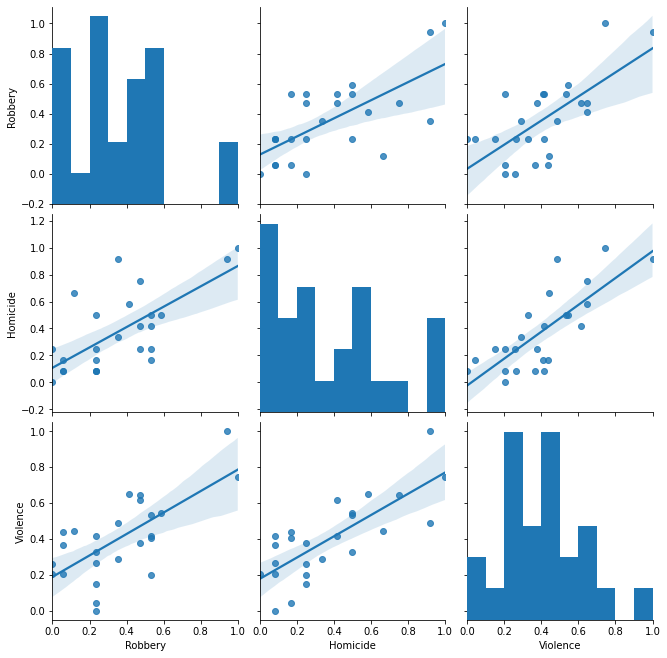

In [89]:
sns.pairplot(crime_analysis_norm, vars=["Robbery", "Homicide", "Violence"], kind='reg', size=3)
plt.show()

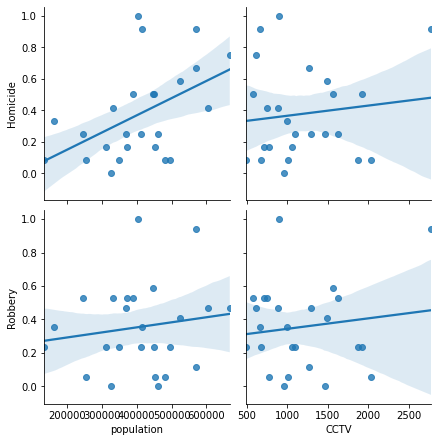

In [91]:
sns.pairplot(crime_analysis_norm, x_vars=["population", "CCTV"], 
             y_vars=["Homicide", "Robbery"], kind='reg', size=3)
plt.show()

# Number of CCTVs and Homicide positively correlated? 
# These cameras might not be a major means to prevent murder....

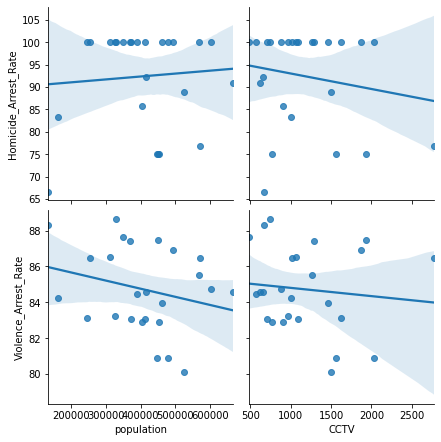

In [92]:
sns.pairplot(crime_analysis_norm, x_vars=["population", "CCTV"], 
             y_vars=["Homicide_Arrest_Rate", "Violence_Arrest_Rate"], kind='reg', size=3)
plt.show()

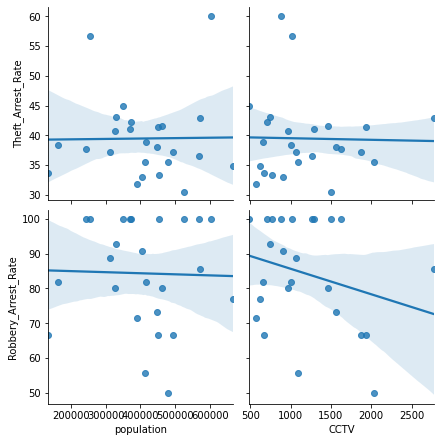

In [93]:
sns.pairplot(crime_analysis_norm, x_vars=["population", "CCTV"], 
             y_vars=["Theft_Arrest_Rate", "Robbery_Arrest_Rate"], kind='reg', size=3)
plt.show()

In [104]:
tmp_max = crime_analysis_norm['Arrested'].max()
crime_analysis_norm['Arrested'] = crime_analysis_norm['Arrested'] / tmp_max * 100
crime_analysis_norm_sort = crime_analysis_norm.sort_values(by='Arrested', ascending=False)
crime_analysis_norm_sort.head()

,Rape,Robbery,Homicide,Theft,Violence,Rape_Arrest_Rate,Robbery_Arrest_Rate,Homicide_Arrest_Rate,Theft_Arrest_Rate,Violence_Arrest_Rate,population,CCTV,Crime,Arrested
borough,,,,,,,,,,,,,,
도봉구,0.000000,0.235294,0.083333,0.000000,0.000000,100.000000,100.0,100.0,44.967074,87.626093,348646,485,0.318627,100.000000
금천구,0.141210,0.058824,0.083333,0.180840,0.202717,80.794702,100.0,100.0,56.668794,86.465433,255082,1015,0.666924,97.997139
강서구,0.461095,0.470588,0.416667,0.370649,0.614945,72.900763,100.0,100.0,60.114504,84.752105,603772,884,2.333944,96.572809
광진구,0.397695,0.529412,0.166667,0.704342,0.406864,91.666667,100.0,100.0,42.200925,83.047619,372164,707,2.204979,96.375820
동대문구,0.204611,0.470588,0.250000,0.329386,0.379335,84.393064,100.0,100.0,41.090358,87.401884,369496,1294,1.633921,95.444250


Now use Folium for further geo-visualization!

In [98]:
map = folium.Map(location=[37.5502, 126.982], zoom_start=11, 
                 tiles='Stamen Toner')

map.choropleth(geo_data = seoul_geo,
               data = crime_analysis_norm['Homicide'],
               columns = [crime_analysis_norm.index, crime_analysis_norm['Homicide']],
               fill_color = 'PuRd', #PuRd, YlGnBu
               key_on = 'feature.id')
map

In [100]:
map = folium.Map(location=[37.5502, 126.982], zoom_start=11, 
                 tiles='Stamen Toner')

map.choropleth(geo_data = seoul_geo,
               data = crime_analysis_norm['Rape'],
               columns = [crime_analysis_norm.index, crime_analysis_norm['Rape']],
               fill_color = 'PuRd', #PuRd, YlGnBu
               key_on = 'feature.id')
map

In [105]:
map = folium.Map(location=[37.5502, 126.982], zoom_start=11, 
                 tiles='Stamen Toner')

map.choropleth(geo_data = seoul_geo,
               data = crime_analysis_norm['Crime'],
               columns = [crime_analysis_norm.index, crime_analysis_norm['Crime']],
               fill_color = 'PuRd', #PuRd, YlGnBu
               key_on = 'feature.id')
map

In [107]:
map = folium.Map(location=[37.5502, 126.982], zoom_start=11, 
                 tiles='Stamen Toner')

map.choropleth(geo_data = seoul_geo,
               data = crime_analysis_norm['Arrested'],
               columns = [crime_analysis_norm.index, crime_analysis_norm['Arrested']],
               fill_color = 'YlGnBu', #PuRd, YlGnBu
               key_on = 'feature.id')
map

In [108]:
df_crime_seoul['lat'] = station_lat
df_crime_seoul['lng'] = station_lng

col = ['Rape_Arrested', 'Robbery_Arrested', 'Homicide_Arrested', 'Theft_Arrested', 'Violence_Arrested']
tmp = df_crime_seoul[col] / df_crime_seoul[col].max()
    
df_crime_seoul['Arrested'] = np.sum(tmp, axis=1)

df_crime_seoul.head()

,Police_Dept,Homicide,Homicide_Arrested,Robbery,Robbery_Arrested,Rape,Rape_Arrested,Theft,Theft_Arrested,Violence,Violence_Arrested,borough,lat,lng,Arrested
0,중부서,2,2,3,2,105,65,1395,477,1355,1170,중구,37.563646,126.989580,1.275416
1,종로서,3,3,6,5,115,98,1070,413,1278,1070,종로구,37.575558,126.984867,1.523847
2,남대문서,1,0,6,4,65,46,1153,382,869,794,중구,37.554758,126.973498,0.907372
3,서대문서,2,2,5,4,154,124,1812,738,2056,1711,서대문구,37.564785,126.966776,1.978299
4,혜화서,3,2,5,4,96,63,1114,424,1015,861,종로구,37.571853,126.998914,1.198382


In [109]:

map = folium.Map(location=[37.5502, 126.982], zoom_start=11)

for n in df_crime_seoul.index:
    folium.Marker([df_crime_seoul['lat'][n], 
                   df_crime_seoul['lng'][n]]).add_to(map)
    
map

In [110]:

map = folium.Map(location=[37.5502, 126.982], zoom_start=11)

for n in df_crime_seoul.index:
    folium.CircleMarker([df_crime_seoul['lat'][n], df_crime_seoul['lng'][n]], 
                        radius = df_crime_seoul['Arrested'][n]*10, 
                        color='#3186cc', fill_color='#3186cc', fill=True).add_to(map)
    
map

In [112]:

map = folium.Map(location=[37.5502, 126.982], zoom_start=11)

map.choropleth(geo_data = seoul_geo,
               data = crime_analysis_norm['Crime'],
               columns = [crime_analysis_norm.index, crime_analysis_norm['Crime']],
               fill_color = 'PuRd', #PuRd, YlGnBu
               key_on = 'feature.id')

for n in df_crime_seoul.index:
    folium.CircleMarker([df_crime_seoul['lat'][n], df_crime_seoul['lng'][n]], 
                        radius = df_crime_seoul['Arrested'][n]*10, 
                        color='#3186cc', fill_color='#3186cc', fill=True).add_to(map)
    
map

If there is a dense area of crime, then police stations with large coverage are placed. Gangnam area, known as a rich place within Seoul, is not so safe place as we think it is.  